In [1]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
import time

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/simgraph/code/my_packages')
# sys.path.append('F:/Users/yasam/Documents/GitHub/simgraph/code/my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import simgraph.my_simgraph as sg
import dataprocess.data_handler_03 as dh

# Train the GLR model on the response of several cell groups

Groups are created using the pairwise interactions extracted from Ben Hoshal's maximum entropy model.

## Load and preprocess the data

In [2]:
# load all spike data from file
spikes_dp = '../../../local_data/original_files/'
binned_data = np.load(spikes_dp+'spikes.npy')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

I_order = np.array([ 54,  35,  10,  60,  74,   9,  61,  56,  91, 104,  39,   7,  29,  68,  81,  41,  75 , 76,
   82,  79,  32,  51,  14,  88,  89,   8, 107,   3,  80,  55, 106,  96,  94, 95,   6,  20,
   83,  87,   1,  97, 103,  28,  18,  16,  85, 101,   2,  52,  11,  71, 108,  38,  25,  53,
  113,  64,  58,  24,  70,  43,  77,  45, 110,  49,  26,  40,  48,  67, 100,  30,  19,  36,
   17,   5,  69,  65,  99, 78,  33,  37,  47,  66,  59,  98,  21,  90,  12,  46,  86,  92,
    4, 112,  62,  50, 105,  27,  13,  93, 102,  63,  34,  31,  84,  23,  44,  15, 109, 111,
   72,  73,  42,  57,  22])
I_order = I_order - 1

In [3]:
# print some statistics
print('binned_data.shape = ', binned_data.shape)
nrepeats, nframes, ncells = binned_data.shape

avg_spike_perc = 0
print('neuron #    | percentage belonging to class 1')
print('---------------------------------------------')
for neu_i in I_order[:10]:
    pers = dh.class_percentages(binned_data[:,:,neu_i].reshape(-1), [-1, 1])
    avg_spike_perc += pers[1]
    print('neuron #{:3} | {:.2f} %'.format(neu_i, pers[1]))

avg_spike_perc /= 10
print('---------------------------------------------')
print('AVERAGE     | {:.2f} % of data belongs to class 1'.format(avg_spike_perc))

total_perc = np.sum(binned_data == 1) * 100 / len(binned_data.reshape(-1))
print('---------------------------------------------')
print('{:.2f} % of the whole data belongs to class 1.'.format(total_perc))

binned_data.shape =  (297, 1141, 113)
neuron #    | percentage belonging to class 1
---------------------------------------------
neuron # 53 | 0.44 %
neuron # 34 | 0.37 %
neuron #  9 | 0.64 %
neuron # 59 | 0.50 %
neuron # 73 | 0.78 %
neuron #  8 | 1.03 %
neuron # 60 | 1.42 %
neuron # 55 | 0.28 %
neuron # 90 | 0.29 %
neuron #103 | 0.97 %
---------------------------------------------
AVERAGE     | 0.67 % of data belongs to class 1
---------------------------------------------
3.00 % of the whole data belongs to class 1.


In [4]:
# load the cell groups from pickle file
# with open('../../data/matlab_data/cell_groups_ising.pkl', 'rb') as file:
#     cell_groups = pickle.load(file)
    
with open('../../data/matlab_data/cell_groups_rtpairwise.pkl', 'rb') as file:
    cell_groups = pickle.load(file)

num_groups = len(cell_groups)
print('number of cell groups:', num_groups)
print('group sizes:', [len(group) for group in cell_groups])

number of cell groups: 3
group sizes: [16, 13, 11]


In [5]:
# create the ORed response of each cell group
group_responses = []

for group_i in range(num_groups):
    group_res = np.zeros((nrepeats, nframes, 1))
    for repeat_i in range(nrepeats):
        for frame_i in range(nframes):
            group_res[repeat_i, frame_i, :] = 2 * int((binned_data[repeat_i, frame_i, cell_groups[group_i]] == 1).any()) - 1
    group_responses.append(group_res)

In [6]:
# split the repeats into experiment and control groups
group_responses_exp = np.zeros((int(np.ceil(nrepeats/2)), nframes, num_groups))
group_responses_cntr = np.zeros((int(np.floor(nrepeats/2)), nframes, num_groups))
for group_i in range(num_groups):
    group_responses_exp[:,:,group_i] = group_responses[group_i][::2, :, 0]
    group_responses_cntr[:,:,group_i] = group_responses[group_i][1::2, :, 0]

print('experiment groups (even repeats):\tnum of repeats =', len(group_responses_exp), '\tshape =', group_responses_exp.shape)
print('control    groups (odd repeats):\tnum of repeats =', len(group_responses_cntr), '\tshape =', group_responses_cntr.shape)

experiment groups (even repeats):	num of repeats = 149 	shape = (149, 1141, 3)
control    groups (odd repeats):	num of repeats = 148 	shape = (148, 1141, 3)


In [7]:
group_responses_exp[:,:,group_i].shape

(149, 1141)

## Create the training and validation datasets

In [8]:
def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

def transform_mnistsift(fv):
    return fv[::4]

def transform_slowfast(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[::200]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

def transform_sift3d(fv):
    return fv[::2]

def transform_soenet(fv):
    return fv[::5]

# data retrieval params
# data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
#                'spike_data': None, 'group_id': None, 'transform': transform_mnistsift, 'ind_min': 0, 'ind_max': 13203, 'feature_id':'mnist-sift'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/slowfast/slowfast_4732_numpy/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_slowfast, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'slowfast'}

data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1_with_kp/desc/', \
               'spike_data': group_responses_exp, 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/soenet/soenet3/features_2layer/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_soenet, 'ind_min': 1*1141+41, 'ind_max': 2*1141-1, 'feature_id':'soenet'}

In [9]:
# choose the cell group
data_params['group_id'] = 0
# choose dataset sizes
train_num = 200
val_num = 100

# optional normalization
# train_data['des'] = dh.normalize(train_data['des'])
# val_data['des'] = dh.normalize(val_data['des'])

# create training and validation datasets
train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, data_params, seed=0)

In [10]:
# show statistics
print('feature_id: ', data_params['feature_id'])
print('train_num = ', train_num, ', val_num = ', val_num)
print('number of features: ', train_data['des'].shape[1])

print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])
print('minimum value of train features: ', np.min(train_data['des']))
print('mean value of train features: ', np.mean(train_data['des']))
print('median value of train features: ', np.median(train_data['des']))
print('maximum value of train features: ', np.max(train_data['des']))

feature_id:  sift3d
train_num =  200 , val_num =  100
number of features:  384
train_smpls =  [1476 1297 1532 1910 1338 1747 1302 1834 1836 1683 1662 1992 1935 1748
 1300 1767 1794 1916 1712 1357 1721 2163 1754 2188 1781 1932 1470 2154
 1622 1390 1676 1772 2164 1454 1327 2141 2180 1797 2007 1938 1718 1868
 2128 1720 1823 1756 1819 2187 1455 1672 2158 1759 1383 1919 1528 1782
 1682 1193 1475 1527 2182 2202 1311 1434 2220 1903 1944 1982 1719 1628
 1884 2047 1189 2149 1316 1507 1807 1658 1345 2148 1468 2170 1957 1808
 2175 2225 1652 2131 1741 1600 2130 1827 1303 1270 1521 2184 1188 1394
 2157 1620 2077 1887 2071 1964 1578 1239 1151 1418 1708 1372 2031 2060
 1288 2233 2087 2254 1842 2240 1892 2280 1561 2160 1694 2269 1736 1170
 1166 1697 2253 1242 1289 1182 1331 1858 1229 2059 2255 1317 1299 1958
 1787 1569 2061 1481 2048 1999 1631 2027 1361 1566 1799 2069 2098 1247
 1745 2245 2054 1984 2231 1953 2265 1596 1184 2079 1849 1853 1994 1262
 2046 2078 2230 1158 1837 1183 1606 1621 1539 1204 161

## Train the GLR model (experiment groups)

In [11]:
# visualize the learned metric matrix
def visualize_M(M, fig_params):
    # unpack params
    rmark_th = fig_params['rmark_th']
    xloc = fig_params['xloc']
    yloc = fig_params['yloc']

    sg.display_matrix(M, None)
    # mark prominent elements          
    lim = (rmark_th/100) * np.max(M) # marker threshold                
    plt.plot(xloc[M > lim],yloc[M > lim], marker='o', markersize=3, color='r', linestyle='')
    plt.title('M - marked above {}%'.format(rmark_th))

In [12]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': 50, 'Dv': 26, 'Dvt': 10, 'mu': 1,\
             'cnstr_method_tt': 'time-glr', 'cnstr_method_vv': 'time-glr', 'cnstr_method_vt': 'time-balanced',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                'num_its':150, 'check_freq':15, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# random parameter for edge selection and B initialization
seed = 0

# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_data['lbls'], sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)
print(len(sg_params['edges_tt']))

4849


In [13]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B_1, fact_stats_1 = sg.fit_graph(train_data['des'], train_data['lbls'], sg_params, gd_opt_params, seed)
fact_M_1 = fact_B_1.T @ fact_B_1
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))

Number of training datapoints: 200
Number of features for each point: 384
mu = 1
   0: eps = 2.12e-01;  train loss (E) = 13684.68
  15: eps = 1.49e-01;  train loss (E) = 671.73
  30: eps = 1.04e-01;  train loss (E) = 670.81
  45: eps = 2.90e-01;  train loss (E) = 670.65
  60: eps = 2.03e-01;  train loss (E) = 670.62
  75: eps = 1.42e-01;  train loss (E) = 670.61
  90: eps = 9.90e-02;  train loss (E) = 670.61
 105: eps = 1.38e-01;  train loss (E) = 670.61
 120: eps = 1.93e-01;  train loss (E) = 670.61
 135: eps = 1.35e-01;  train loss (E) = 670.61
 149: eps = 2.22e-01;  train loss (E) = 670.61
Elapsed  time: 274.601241 sec


In [14]:
# validate exp: 1st model
fact_val_acc_1, fact_y_est_1, fact_t_1 = sg.get_acc(fact_M_1, train_data['des'], train_data['lbls'], 
                                                    val_data['des'], val_data['lbls'], sg_params, 'binary', 
                                                    seed, show_edges=False)
print('Elapsed time: {:.6f} sec'.format(fact_t_1))
print('GLR val. acc. = {:.6f}'.format(fact_val_acc_1))

Elapsed time: 0.106445 sec
GLR val. acc. = 0.660000


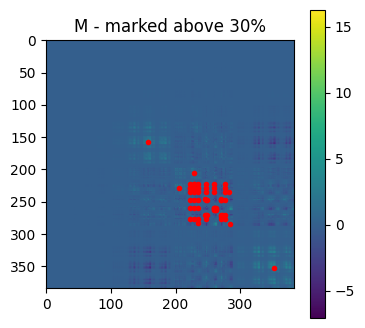

In [15]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}
visualize_M(fact_M_1, fig_params)

## Train the GLR model (exp: 2nd group)

In [16]:
# update the labels based on the 2nd group's response
data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1_with_kp/desc/', \
               'spike_data': group_responses_exp, 'group_id': 1, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

_, train_lbls_2 = dh.update_set(train_data['smpls'], data_params)
_, val_lbls_2 = dh.update_set(val_data['smpls'], data_params)

In [17]:
val_lbls_2

array([-1., -1., -1.,  1.,  1., -1.,  1., -1., -1., -1.,  1., -1.,  1.,
        1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
       -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,
        1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.,
        1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,
       -1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.,  1., -1., -1., -1., -1., -1., -1., -1.])

In [18]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': 50, 'Dv': 26, 'Dvt': 10, 'mu': 1,\
             'cnstr_method_tt': 'time-glr', 'cnstr_method_vv': 'time-glr', 'cnstr_method_vt': 'time-balanced',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                'num_its':150, 'check_freq':15, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# random parameter for edge selection and B initialization
seed = 0

# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_lbls_2, sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)
print(len(sg_params['edges_tt']))

2600


In [19]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B_2, fact_stats_2 = sg.fit_graph(train_data['des'], train_lbls_2, sg_params, gd_opt_params, seed)
fact_M_2 = fact_B_2.T @ fact_B_2
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))

Number of training datapoints: 200
Number of features for each point: 384
mu = 1
   0: eps = 2.12e-01;  train loss (E) = 4291.32
  15: eps = 1.49e-01;  train loss (E) = 446.29
  30: eps = 1.04e-01;  train loss (E) = 445.90
  45: eps = 1.45e-01;  train loss (E) = 445.85
  60: eps = 2.03e-01;  train loss (E) = 445.84
  75: eps = 1.42e-01;  train loss (E) = 445.84
  90: eps = 1.98e-01;  train loss (E) = 445.83
 105: eps = 2.77e-01;  train loss (E) = 445.83
 120: eps = 1.93e-01;  train loss (E) = 445.83
 135: eps = 1.35e-01;  train loss (E) = 445.83
 149: eps = 2.22e-01;  train loss (E) = 445.83
Elapsed  time: 136.552419 sec


In [20]:
# exp: 2nd model
fact_val_acc_2, fact_y_est_2, fact_t_2 = sg.get_acc(fact_M_2, train_data['des'], train_lbls_2, 
                                                    val_data['des'], val_lbls_2, sg_params, 'binary', 
                                                    seed, show_edges=False)
print('Elapsed time: {:.6f} sec'.format(fact_t_2))
print('GLR val. acc. = {:.6f}'.format(fact_val_acc_2))

Elapsed time: 0.103299 sec
GLR val. acc. = 0.650000


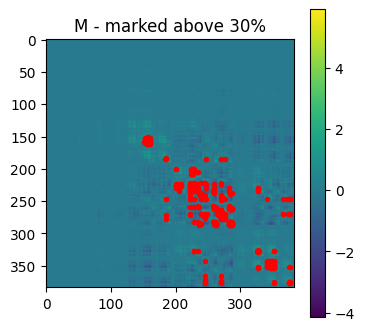

In [21]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}

visualize_M(fact_M_2, fig_params)

## Train the GLR model (exp: 3rd group)

In [22]:
# update the labels based on the 2nd group's response
data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1_with_kp/desc/', \
               'spike_data': group_responses_exp, 'group_id': 2, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

_, train_lbls_3 = dh.update_set(train_data['smpls'], data_params)
_, val_lbls_3 = dh.update_set(val_data['smpls'], data_params)

In [23]:
val_lbls_3

array([-1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1., -1., -1.,
       -1., -1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,
        1.,  1.,  1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,
       -1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,
       -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
       -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1., -1.,
       -1.,  1., -1., -1.,  1., -1., -1., -1., -1.])

In [24]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': 50, 'Dv': 26, 'Dvt': 10, 'mu': 1,\
             'cnstr_method_tt': 'time-glr', 'cnstr_method_vv': 'time-glr', 'cnstr_method_vt': 'time-balanced',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                'num_its':150, 'check_freq':15, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# random parameter for edge selection and B initialization
seed = 0

# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_lbls_3, sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)
print(len(sg_params['edges_tt']))

2750


In [25]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B_3, fact_stats_3 = sg.fit_graph(train_data['des'], train_lbls_3, sg_params, gd_opt_params, seed)
fact_M_3 = fact_B_3.T @ fact_B_3
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))

Number of training datapoints: 200
Number of features for each point: 384
mu = 1
   0: eps = 2.12e-01;  train loss (E) = 5057.05
  15: eps = 1.49e-01;  train loss (E) = 510.16
  30: eps = 2.08e-01;  train loss (E) = 509.81
  45: eps = 1.45e-01;  train loss (E) = 509.78
  60: eps = 2.03e-01;  train loss (E) = 509.77
  75: eps = 1.42e-01;  train loss (E) = 509.77
  90: eps = 1.98e-01;  train loss (E) = 509.77
 105: eps = 1.38e-01;  train loss (E) = 509.77
 120: eps = 1.93e-01;  train loss (E) = 509.77
 135: eps = 2.70e-01;  train loss (E) = 509.77
 149: eps = 2.22e-01;  train loss (E) = 509.77
Elapsed  time: 149.851611 sec


In [26]:
# exp: 3rd model
fact_val_acc_3, fact_y_est_3, fact_t_3 = sg.get_acc(fact_M_3, train_data['des'], train_lbls_3, 
                                                    val_data['des'], val_lbls_3, sg_params, 'binary', 
                                                    seed, show_edges=False)
print('Elapsed time: {:.6f} sec'.format(fact_t_3))
print('GLR val. acc. = {:.6f}'.format(fact_val_acc_3))

Elapsed time: 0.090323 sec
GLR val. acc. = 0.740000


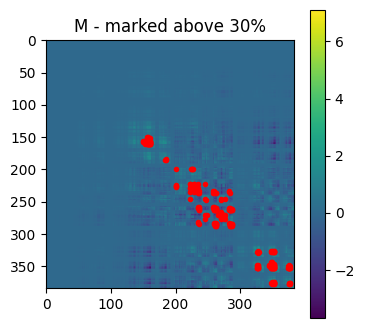

In [27]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}
visualize_M(fact_M_3, fig_params)

## Compare the three groups

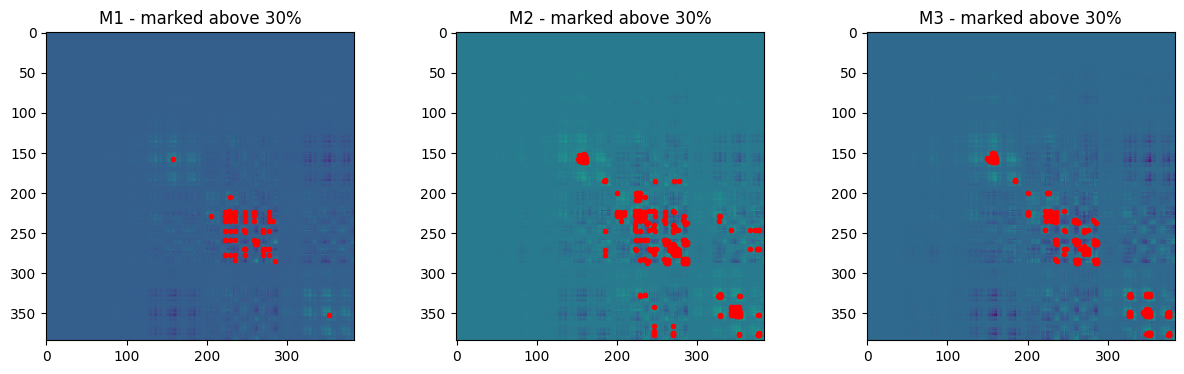

In [29]:
# print the optimized M
rmark_th = fig_params['rmark_th']
xloc = fig_params['xloc']
yloc = fig_params['yloc']

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(fact_M_1)   
lim = (rmark_th/100) * np.max(fact_M_1) # marker threshold                
plt.plot(xloc[fact_M_1 > lim],yloc[fact_M_1 > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M1 - marked above {}%'.format(rmark_th))

plt.subplot(1,3,2)
plt.imshow(fact_M_2)
lim = (rmark_th/100) * np.max(fact_M_2) # marker threshold                
plt.plot(xloc[fact_M_2 > lim],yloc[fact_M_2 > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M2 - marked above {}%'.format(rmark_th))

plt.subplot(1,3,3)
plt.imshow(fact_M_3)
lim = (rmark_th/100) * np.max(fact_M_3) # marker threshold                
plt.plot(xloc[fact_M_3 > lim],yloc[fact_M_3 > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M3 - marked above {}%'.format(rmark_th))

plt.savefig('image/Ms.png',dpi=300, bbox_inches = "tight")

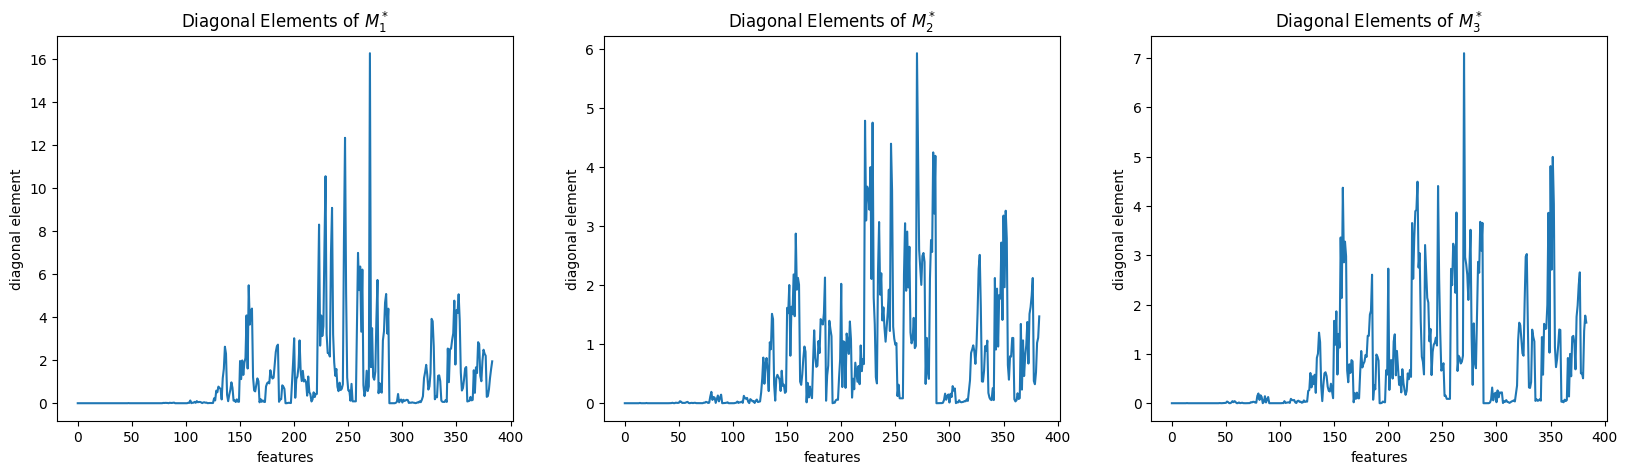

In [30]:
# print the diagonal elements of M
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(fact_M_1.diagonal())
plt.xlabel('features')
plt.ylabel('diagonal element')
plt.title('Diagonal Elements of $M_1^*$')

plt.subplot(1,3,2)
plt.plot(fact_M_2.diagonal())
plt.xlabel('features')
plt.ylabel('diagonal element')
plt.title('Diagonal Elements of $M_2^*$')

plt.subplot(1,3,3)
plt.plot(fact_M_3.diagonal())
plt.xlabel('features')
plt.ylabel('diagonal element')
plt.title('Diagonal Elements of $M_3^*$')

plt.savefig('image/diagonals.png',dpi=300, bbox_inches = "tight")

The largest eigenvalues of M1:
 [1.20527045e+02 9.55805840e+01 8.35896033e+01 5.82277535e+01
 3.80489179e+01 1.51928782e+01 8.90885639e-06 6.26490181e-11
 9.84529403e-15 9.84529403e-15]
The largest eigenvalues of M2:
 [6.66308887e+01 6.47951076e+01 6.08676542e+01 4.49859232e+01
 3.68628396e+01 7.20721769e+00 4.43939466e-04 2.56685104e-08
 1.46131483e-11 6.43036910e-15]
The largest eigenvalues of M3:
 [8.12334033e+01 6.95837773e+01 6.11334250e+01 4.36598448e+01
 4.04567276e+01 1.77392777e+00 1.61421525e-06 2.99976484e-10
 7.47788629e-15 6.82858820e-15]


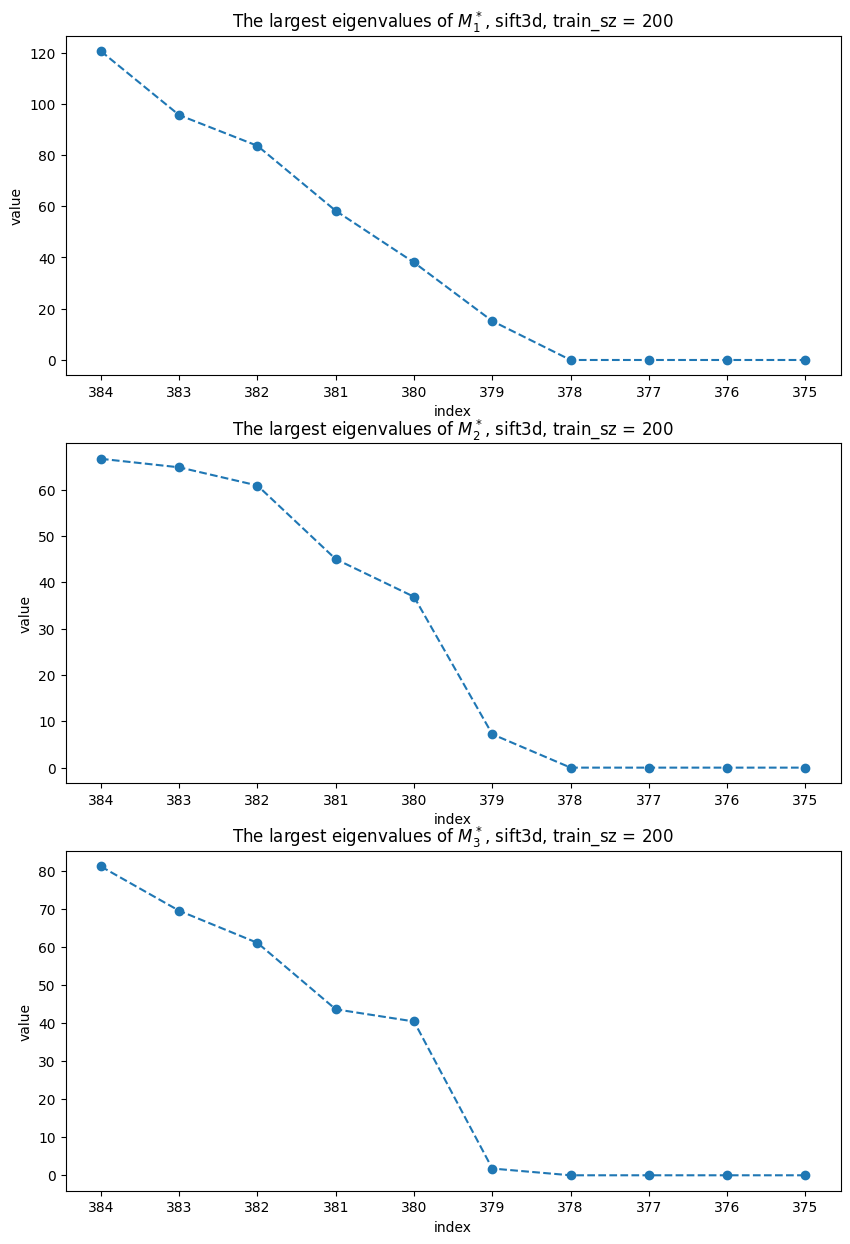

In [31]:
# print the eigenvalues
num_eig = 10
eigvals_1 = np.sort(np.real(np.linalg.eigvals(fact_M_1)))
eigvals_2 = np.sort(np.real(np.linalg.eigvals(fact_M_2)))
eigvals_3 = np.sort(np.real(np.linalg.eigvals(fact_M_3)))

print('The largest eigenvalues of M1:\n', eigvals_1[-1:-num_eig-1:-1])
print('The largest eigenvalues of M2:\n', eigvals_2[-1:-num_eig-1:-1])
print('The largest eigenvalues of M3:\n', eigvals_3[-1:-num_eig-1:-1])

x = eigvals_1.shape[0] - np.arange(num_eig)
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.plot(np.arange(num_eig), np.real(eigvals_1[-1:-num_eig-1:-1]), marker='o', linestyle='--')
_ = plt.xticks(np.arange(num_eig), x)
plt.xlabel('index')
plt.ylabel('value')
plt.title('The largest eigenvalues of $M_1^*$, {}, train_sz = {}'.format(data_params['feature_id'], train_num))

plt.subplot(3,1,2)
plt.plot(np.arange(num_eig), np.real(eigvals_2[-1:-num_eig-1:-1]), marker='o', linestyle='--')
_ = plt.xticks(np.arange(num_eig), x)
plt.xlabel('index')
plt.ylabel('value')
plt.title('The largest eigenvalues of $M_2^*$, {}, train_sz = {}'.format(data_params['feature_id'], train_num))

plt.subplot(3,1,3)
plt.plot(np.arange(num_eig), np.real(eigvals_3[-1:-num_eig-1:-1]), marker='o', linestyle='--')
_ = plt.xticks(np.arange(num_eig), x)
plt.xlabel('index')
plt.ylabel('value')
plt.title('The largest eigenvalues of $M_3^*$, {}, train_sz = {}'.format(data_params['feature_id'], train_num))

plt.savefig('image/eigvals.png',dpi=300, bbox_inches = "tight")

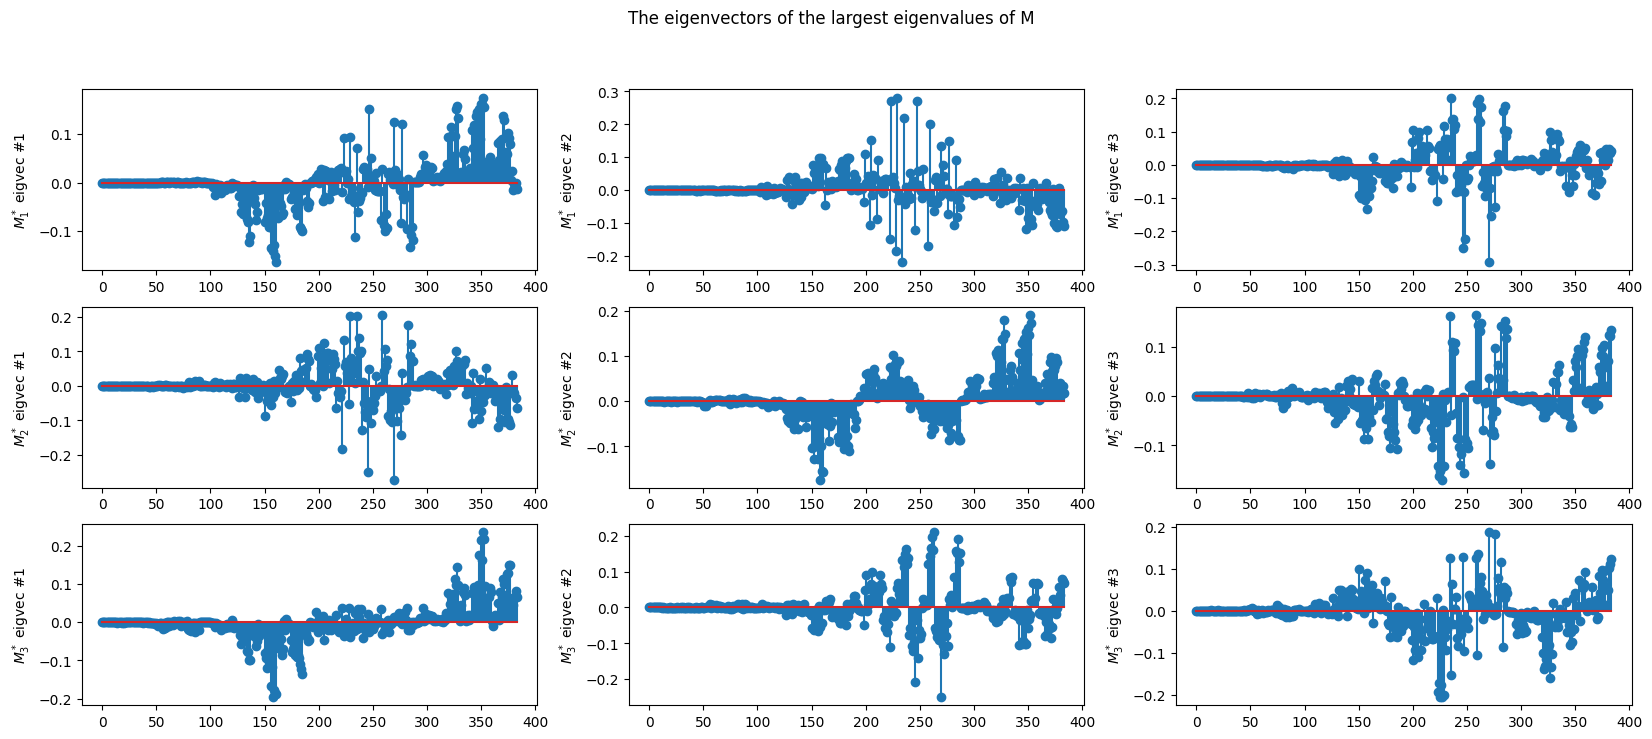

In [38]:
# plot the top eigenvectors for each cell group
num_eigvecs = 3
eigvals, eigvecs = np.linalg.eig(fact_M_1)
sorted_eigvals = sorted(list(zip(np.arange(eigvals.shape[0]), np.real(eigvals))), key = lambda x: x[1], reverse=True)
maxeig_ind = [ind for (ind, eigval) in sorted_eigvals[0:num_eigvecs]]
maxeig_vecs_1 = eigvecs[: ,maxeig_ind]

eigvals, eigvecs = np.linalg.eig(fact_M_2)
sorted_eigvals = sorted(list(zip(np.arange(eigvals.shape[0]), np.real(eigvals))), key = lambda x: x[1], reverse=True)
maxeig_ind = [ind for (ind, eigval) in sorted_eigvals[0:num_eigvecs]]
maxeig_vecs_2 = eigvecs[: ,maxeig_ind]

eigvals, eigvecs = np.linalg.eig(fact_M_3)
sorted_eigvals = sorted(list(zip(np.arange(eigvals.shape[0]), np.real(eigvals))), key = lambda x: x[1], reverse=True)
maxeig_ind = [ind for (ind, eigval) in sorted_eigvals[0:num_eigvecs]]
maxeig_vecs_3 = eigvecs[: ,maxeig_ind]

# plot the eigenvectors
xs = np.arange(maxeig_vecs_1.shape[0])
plt.figure(figsize=(20,8))
for i in range(num_eigvecs):
    plt.subplot(3,num_eigvecs,i+1)
    plt.stem(xs, np.real(maxeig_vecs_1[:,i]))
    plt.ylabel('$M_1^*$ eigvec #{}'.format(i+1))

for i in range(num_eigvecs):
    plt.subplot(3,num_eigvecs,num_eigvecs+i+1)
    plt.stem(xs, np.real(maxeig_vecs_2[:,i]))
    plt.ylabel('$M_2^*$ eigvec #{}'.format(i+1))
    
for i in range(num_eigvecs):
    plt.subplot(3,num_eigvecs,2*num_eigvecs+i+1)
    plt.stem(xs, np.real(maxeig_vecs_3[:,i]))
    plt.ylabel('$M_3^*$ eigvec #{}'.format(i+1))
    
_ = plt.suptitle('The eigenvectors of the largest eigenvalues of M')
plt.savefig('image/eigvecs.png',dpi=300, bbox_inches = "tight")

## Train for the control groups

In [33]:
similarity_1 = np.sum(group_responses_exp[:-1,:,0] == group_responses_cntr[:,:,0]) / nframes / np.floor(nrepeats/2)
print('The control group #1 is {:.2f}% similar to the experiment group'.format(similarity_1*100))

similarity_2 = np.sum(group_responses_exp[:-1,:,1] == group_responses_cntr[:,:,1]) / nframes / np.floor(nrepeats/2)
print('The control group #2 is {:.2f}% similar to the experiment group'.format(similarity_2*100))

similarity_3 = np.sum(group_responses_exp[:-1,:,2] == group_responses_cntr[:,:,2]) / nframes / np.floor(nrepeats/2)
print('The control group #3 is {:.2f}% similar to the experiment group'.format(similarity_3*100))

The control group #1 is 77.44% similar to the experiment group
The control group #2 is 76.74% similar to the experiment group
The control group #3 is 75.92% similar to the experiment group


In [40]:
# save all three M matrices
np.save('matrices/exp_M_1.npy',fact_M_1)
np.save('matrices/exp_M_2.npy',fact_M_2)
np.save('matrices/exp_M_3.npy',fact_M_3)

## Train the GLR model (cntr: 1st group)

In [34]:
# update the labels based on the 2nd group's response
data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1_with_kp/desc/', \
               'spike_data': group_responses_cntr, 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

_, train_lbls_1c = dh.update_set(train_data['smpls'], data_params)
_, val_lbls_1c = dh.update_set(val_data['smpls'], data_params)

In [35]:
val_lbls_1c

array([ 1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
        1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
        1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,
        1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,
       -1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1.,  1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [36]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': None, 'Dv': None, 'Dvt': None, 'mu': 30,\
             'cnstr_method_tt': 'time-glr', 'cnstr_method_vv': 'time-glr', 'cnstr_method_vt': 'time-balanced',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                'num_its':150, 'check_freq':15, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# random parameter for edge selection and B initialization
seed = 0

# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_lbls_1c, sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)
print(len(sg_params['edges_tt']))

9991


In [ ]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B_1c, fact_stats_1c = sg.fit_graph(train_data['des'], train_lbls_1c, sg_params, gd_opt_params, seed)
fact_M_1c = fact_B_1c.T @ fact_B_1c
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))

In [ ]:
# exp: 3rd model
fact_val_acc_1c, fact_y_est_1c, fact_t_1c = sg.get_acc(fact_M_1c, train_data['des'], train_lbls_1c, 
                                                    val_data['des'], val_lbls_1c, sg_params, 'binary', 
                                                    seed, show_edges=False)
print('Elapsed time: {:.6f} sec'.format(fact_t_1c))
print('GLR val. acc. = {:.6f}'.format(fact_val_acc_1c))

In [ ]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}
visualize_M(fact_M_1c, fig_params)

## Train the GLR model (cntr: 2nd group)

In [ ]:
# update the labels based on the 2nd group's response
data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1_with_kp/desc/', \
               'spike_data': group_responses_cntr, 'group_id': 1, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

_, train_lbls_2c = dh.update_set(train_data['smpls'], data_params)
_, val_lbls_2c = dh.update_set(val_data['smpls'], data_params)

In [ ]:
val_lbls_2c

In [ ]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': None, 'Dv': None, 'Dvt': None, 'mu': 30,\
             'cnstr_method_tt': 'time-glr', 'cnstr_method_vv': 'time-glr', 'cnstr_method_vt': 'time-balanced',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                'num_its':150, 'check_freq':15, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# random parameter for edge selection and B initialization
seed = 0

# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_lbls_2c, sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)
print(len(sg_params['edges_tt']))

In [ ]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B_2c, fact_stats_2c = sg.fit_graph(train_data['des'], train_lbls_2c, sg_params, gd_opt_params, seed)
fact_M_2c = fact_B_2c.T @ fact_B_2c
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))

In [ ]:
# exp: 3rd model
fact_val_acc_2c, fact_y_est_2c, fact_t_2c = sg.get_acc(fact_M_2, train_data['des'], train_lbls_2c, 
                                                    val_data['des'], val_lbls_2c, sg_params, 'binary', 
                                                    seed, show_edges=False)
print('Elapsed time: {:.6f} sec'.format(fact_t_2c))
print('GLR val. acc. = {:.6f}'.format(fact_val_acc_2c))

In [ ]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}
visualize_M(fact_M_2c, fig_params)

## Train the GLR model (cntr: 3rd group)

In [ ]:
# update the labels based on the 2nd group's response
data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1_with_kp/desc/', \
               'spike_data': group_responses_cntr, 'group_id': 2, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

_, train_lbls_3c = dh.update_set(train_data['smpls'], data_params)
_, val_lbls_3c = dh.update_set(val_data['smpls'], data_params)

In [ ]:
val_lbls_3c

In [ ]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': None, 'Dv': None, 'Dvt': None, 'mu': 30,\
             'cnstr_method_tt': 'time-glr', 'cnstr_method_vv': 'time-glr', 'cnstr_method_vt': 'time-balanced',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                'num_its':150, 'check_freq':15, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# random parameter for edge selection and B initialization
seed = 0

# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_lbls_3c, sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)
print(len(sg_params['edges_tt']))

In [ ]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B_3c, fact_stats_3c = sg.fit_graph(train_data['des'], train_lbls_3c, sg_params, gd_opt_params, seed)
fact_M_3c = fact_B_3c.T @ fact_B_3c
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))

In [ ]:
# exp: 3rd model
fact_val_acc_3c, fact_y_est_3c, fact_t_3c = sg.get_acc(fact_M_3, train_data['des'], train_lbls_3c, 
                                                    val_data['des'], val_lbls_3c, sg_params, 'binary', 
                                                    seed, show_edges=False)
print('Elapsed time: {:.6f} sec'.format(fact_t_3c))
print('GLR val. acc. = {:.6f}'.format(fact_val_acc_3c))

In [ ]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}
visualize_M(fact_M_3c, fig_params)

## Compare the control groups together

In [ ]:
# print the optimized M
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}
rmark_th = fig_params['rmark_th']
xloc = fig_params['xloc']
yloc = fig_params['yloc']

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(fact_M_1c)   
lim = (rmark_th/100) * np.max(fact_M_1c) # marker threshold                
plt.plot(xloc[fact_M_1c > lim],yloc[fact_M_1c > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M1 - marked above {}%'.format(rmark_th))

plt.subplot(1,3,2)
plt.imshow(fact_M_2c)
lim = (rmark_th/100) * np.max(fact_M_2c) # marker threshold                
plt.plot(xloc[fact_M_2c > lim],yloc[fact_M_2c > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M2 - marked above {}%'.format(rmark_th))

plt.subplot(1,3,3)
plt.imshow(fact_M_3c)
lim = (rmark_th/100) * np.max(fact_M_3c) # marker threshold                
plt.plot(xloc[fact_M_3c > lim],yloc[fact_M_3c > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M3 - marked above {}%'.format(rmark_th))

plt.savefig('image/Ms_cntr.png',dpi=300, bbox_inches = "tight")

In [ ]:
# print the diagonal elements of M
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(fact_M_1c.diagonal())
plt.xlabel('features')
plt.ylabel('diagonal element')
plt.title('Diagonal Elements of $M_1^*$')

plt.subplot(1,3,2)
plt.plot(fact_M_2c.diagonal())
plt.xlabel('features')
plt.ylabel('diagonal element')
plt.title('Diagonal Elements of $M_2^*$')

plt.subplot(1,3,3)
plt.plot(fact_M_3c.diagonal())
plt.xlabel('features')
plt.ylabel('diagonal element')
plt.title('Diagonal Elements of $M_3^*$')

plt.savefig('image/diagonals_cntr.png',dpi=300, bbox_inches = "tight")

In [ ]:
# print the eigenvalues
num_eig = 10
eigvals_1 = np.sort(np.real(np.linalg.eigvals(fact_M_1c)))
eigvals_2 = np.sort(np.real(np.linalg.eigvals(fact_M_2c)))
eigvals_3 = np.sort(np.real(np.linalg.eigvals(fact_M_3c)))

print('The largest eigenvalues of M1:\n', eigvals_1[-1:-num_eig-1:-1])
print('The largest eigenvalues of M2:\n', eigvals_2[-1:-num_eig-1:-1])
print('The largest eigenvalues of M3:\n', eigvals_3[-1:-num_eig-1:-1])

x = eigvals_1.shape[0] - np.arange(num_eig)
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.plot(np.arange(num_eig), np.real(eigvals_1[-1:-num_eig-1:-1]), marker='o', linestyle='--')
_ = plt.xticks(np.arange(num_eig), x)
plt.xlabel('index')
plt.ylabel('value')
plt.title('The largest eigenvalues of $M_1^*$, {}, train_sz = {}'.format(data_params['feature_id'], train_num))

plt.subplot(3,1,2)
plt.plot(np.arange(num_eig), np.real(eigvals_2[-1:-num_eig-1:-1]), marker='o', linestyle='--')
_ = plt.xticks(np.arange(num_eig), x)
plt.xlabel('index')
plt.ylabel('value')
plt.title('The largest eigenvalues of $M_2^*$, {}, train_sz = {}'.format(data_params['feature_id'], train_num))

plt.subplot(3,1,3)
plt.plot(np.arange(num_eig), np.real(eigvals_3[-1:-num_eig-1:-1]), marker='o', linestyle='--')
_ = plt.xticks(np.arange(num_eig), x)
plt.xlabel('index')
plt.ylabel('value')
plt.title('The largest eigenvalues of $M_3^*$, {}, train_sz = {}'.format(data_params['feature_id'], train_num))

plt.savefig('image/eigvals_cntr.png',dpi=300, bbox_inches = "tight")

In [ ]:
# plot the top eigenvectors for each cell group
num_eigvecs = 3
eigvals, eigvecs = np.linalg.eig(fact_M_1c)
sorted_eigvals = sorted(list(zip(np.arange(eigvals.shape[0]), np.real(eigvals))), key = lambda x: x[1], reverse=True)
maxeig_ind = [ind for (ind, eigval) in sorted_eigvals[0:num_eigvecs]]
maxeig_vecs_1c = eigvecs[: ,maxeig_ind]

eigvals, eigvecs = np.linalg.eig(fact_M_2c)
sorted_eigvals = sorted(list(zip(np.arange(eigvals.shape[0]), np.real(eigvals))), key = lambda x: x[1], reverse=True)
maxeig_ind = [ind for (ind, eigval) in sorted_eigvals[0:num_eigvecs]]
maxeig_vecs_2c = eigvecs[: ,maxeig_ind]

eigvals, eigvecs = np.linalg.eig(fact_M_3c)
sorted_eigvals = sorted(list(zip(np.arange(eigvals.shape[0]), np.real(eigvals))), key = lambda x: x[1], reverse=True)
maxeig_ind = [ind for (ind, eigval) in sorted_eigvals[0:num_eigvecs]]
maxeig_vecs_3c = eigvecs[: ,maxeig_ind]

# plot the eigenvectors
xs = np.arange(maxeig_vecs_1c.shape[0])
plt.figure(figsize=(20,8))
for i in range(num_eigvecs):
    plt.subplot(3,num_eigvecs,i+1)
    plt.plot(xs, np.real(maxeig_vecs_1c[:,i]))
    plt.ylabel('$M_1^*$ eigvec #{}'.format(i+1))

for i in range(num_eigvecs):
    plt.subplot(3,num_eigvecs,num_eigvecs+i+1)
    plt.plot(xs, np.real(maxeig_vecs_2c[:,i]))
    plt.ylabel('$M_2^*$ eigvec #{}'.format(i+1))
    
for i in range(num_eigvecs):
    plt.subplot(3,num_eigvecs,2*num_eigvecs+i+1)
    plt.plot(xs, np.real(maxeig_vecs_3c[:,i]))
    plt.ylabel('$M_3^*$ eigvec #{}'.format(i+1))
    
_ = plt.suptitle('The eigenvectors of the largest eigenvalues of M')
plt.savefig('image/eigvecs_cntr.png',dpi=300, bbox_inches = "tight")